In [11]:
# Package imports
import itertools
import pandas as pd
import preprocessor as p
import re
import sklearn.feature_extraction
import string
import unidecode
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from langdetect import detect
import seaborn as sns
import spacy

# Lambda function for printing
debug = lambda x: print(x)

In [6]:
# Create punctuation removal variable
rm_punc = str.maketrans('', '', string.punctuation)

# Create stopword removal variable
stopwords = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
temp_word = set(stopwords)
new_words_temp = [] # <- Add any additional stopwords here
for i in new_words_temp:
    temp_word.add(i)
stopwords = frozenset(temp_word)

# Create stemmer variables
porter = PorterStemmer()
lancaster = LancasterStemmer()

In [35]:
# Import JSON files containing tweet dataset(s)
tweets = pd.read_json('/Users/tomashegewisch/Downloads/20200301-20200331.json', lines=True, orient='record')

# View all rows contained in the dataset(s)
pd.set_option('display.max_rows', tweets.shape[0]+1)

In [36]:
# Check for duplicate tweets
debug("BEFORE")
debug(len(tweets))
tweets.drop_duplicates(subset=['id'], keep="first", inplace=True)
debug("\nAFTER")
debug(len(tweets))

BEFORE
235341

AFTER
51243


In [37]:
# Remove all tweets which are not English
def language(text):
    try:
        return detect(text)
    except:
        return "en"
    
debug(len(tweets))
tweets = tweets[tweets['tweet'].apply(language) == "en"]
debug(len(tweets))

51243
48004


In [42]:
# Stopword and link removal
def remove_stopwords(word):
    if word in stopwords:
        return ''
    if word.startswith('http') or word.startswith('pictwittercom') or word.endswith('com') or word.endswith('coza'):
        return ''
    return word

# Preprocessing the tweet
def preprocess(text):
    clean_data = []
    for x in text:
        new_text = re.sub('<.*?>', '', x)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punctuation
        new_text = re.sub(r'\d+','',new_text) # remove numbers
        new_text = re.sub('\n', ' ', new_text) #remove escape characters
        new_text = new_text.lower() # lower case         
        if new_text != '':
            clean_data.append(new_text)
        temp_string = ''
        for i in clean_data:
            temp_string += i
    clean_data = temp_string
    return clean_data

# Cleaning and tokenising the tweet
def clean_tweet(tweet):
    tweet = preprocess(tweet)
    tweet = unidecode.unidecode(tweet).lower().split()
    tweet = [remove_stopwords(x) for x in tweet]
    tweet = list(itertools.chain.from_iterable([x.split() for x in tweet if x != '']))
    tweet = [x for x in tweet if len(x) > 1]
    return tweet

In [43]:
tweets['tokenised'] = tweets['tweet'].apply(clean_tweet)

In [ ]:
debug(preprocess("Hi my name is Jack the Quack *snort snort*"))

In [44]:
def find_non_text(text):
    if text == []:
        return "NA"

In [45]:
#DROP rows that do not have text in them...
debug("Before")
debug(len(tweets))
tweets = tweets[tweets['tokenised'].apply(find_non_text) != "NA"]
debug("After")
debug(len(tweets))

Before
48004
After
48004


<AxesSubplot:>

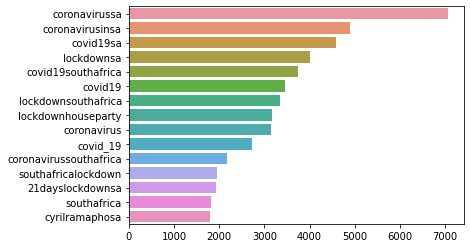

In [40]:
hastags = []
temp = []
for i in tweets["hashtags"]:
    try:
        if i != []:
            for j in i:
                hastags.append(j)
    except:
        pass

count = Counter(hastags)
x,y=list(map(list,zip(*count.most_common(15))))
sns.barplot(x=y,y=x)

In [28]:
#YOU MUST FIRST RUN THIS COMMAND python3 -m spacy download en_core_web_sm
# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')
doc = nlp('South Africa and Canada are going to talk next thursday in Cape Town')
[(x.text,x.label_) for x in doc.ents]
#displacy.render(doc, style='ent')

len(tweets)

6347

KeyError: 'tokenised'

In [41]:
tweets.to_pickle("March.pkl")

In [ ]:
tweets = tweets.read_pickle("March.pkl")